[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">](https://github.com/jeshraghian/snntorch/)

# snnTorch - The Leaky Integrate and Fire Neuron
## Tutorial 2
### By Jason K. Eshraghian (www.ncg.ucsc.edu)
### 偏白话文翻译： manesec

<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_2_lif_neuron.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub-Mark-Light-120px-plus.png?raw=true' width="28">](https://github.com/jeshraghian/snntorch/) [<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub_Logo_White.png?raw=true' width="80">](https://github.com/jeshraghian/snntorch/)


snnTorch 教程系列基于以下论文。如果您发现这些资源或代码对您有帮助，请考虑引用以下来源：

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". arXiv preprint arXiv:2109.12894, September 2021.](https://arxiv.org/abs/2109.12894) </cite>


# 介绍

在本教程中，您将：
* 了解 带泄漏整合发放模型 (LIF) 神经元模型的基础知识
* 使用 snnTorch 实现一阶 LIF 神经元

 单击以下单元格并按 “Shift+Enter”，安装 snnTorch 的最新 PyPi 发行版。

In [1]:
!pip install snntorch

In [2]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

In [3]:
#@title Plotting Settings
def plot_mem(mem, title=False):
  if title:
    plt.title(title)
  plt.plot(mem)
  plt.xlabel("Time step")
  plt.ylabel("Membrane Potential")
  plt.xlim([0, 50])
  plt.ylim([0, 1])
  plt.show()

def plot_step_current_response(cur_in, mem_rec, vline1):
  fig, ax = plt.subplots(2, figsize=(8,6),sharex=True)

  # Plot input current
  ax[0].plot(cur_in, c="tab:orange")
  ax[0].set_ylim([0, 0.2])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  ax[0].set_title("Lapicque's Neuron Model With Step Input")

  # Plot membrane potential
  ax[1].plot(mem_rec)
  ax[1].set_ylim([0, 0.6])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")

  if vline1:
    ax[1].axvline(x=vline1, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.xlabel("Time step")

  plt.show()


def plot_current_pulse_response(cur_in, mem_rec, title, vline1=False, vline2=False, ylim_max1=False):

  fig, ax = plt.subplots(2, figsize=(8,6),sharex=True)

  # Plot input current
  ax[0].plot(cur_in, c="tab:orange")
  if not ylim_max1:
    ax[0].set_ylim([0, 0.2])
  else:
    ax[0].set_ylim([0, ylim_max1])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem_rec)
  ax[1].set_ylim([0, 1])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")

  if vline1:
    ax[1].axvline(x=vline1, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  if vline2:
    ax[1].axvline(x=vline2, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.xlabel("Time step")

  plt.show()

def compare_plots(cur1, cur2, cur3, mem1, mem2, mem3, vline1, vline2, vline3, vline4, title):
  # Generate Plots
  fig, ax = plt.subplots(2, figsize=(8,6),sharex=True)

  # Plot input current
  ax[0].plot(cur1)
  ax[0].plot(cur2)
  ax[0].plot(cur3)
  ax[0].set_ylim([0, 0.2])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem1)
  ax[1].plot(mem2)
  ax[1].plot(mem3)
  ax[1].set_ylim([0, 1])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")

  ax[1].axvline(x=vline1, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  ax[1].axvline(x=vline2, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  ax[1].axvline(x=vline3, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  ax[1].axvline(x=vline4, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)

  plt.xlabel("Time step")

  plt.show()

def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True,
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, 0.4])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([])

  plt.show()

def plot_spk_mem_spk(spk_in, mem, spk_out, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True,
                        gridspec_kw = {'height_ratios': [0.4, 1, 0.4]})

  # Plot input current
  splt.raster(spk_in, ax[0], s=400, c="black", marker="|")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)
  plt.yticks([])

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, 1])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  ax[1].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk_rec, ax[2], s=400, c="black", marker="|")
  plt.ylabel("Output spikes")
  plt.yticks([])

  plt.show()


def plot_reset_comparison(spk_in, mem_rec, spk_rec, mem_rec0, spk_rec0):
  # Generate Plots to Compare Reset Mechanisms
  fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,6), sharex=True,
                        gridspec_kw = {'height_ratios': [0.4, 1, 0.4], 'wspace':0.05})

  # Reset by Subtraction: input spikes
  splt.raster(spk_in, ax[0][0], s=400, c="black", marker="|")
  ax[0][0].set_ylabel("Input Spikes")
  ax[0][0].set_title("Reset by Subtraction")
  ax[0][0].set_yticks([])

  # Reset by Subtraction: membrane potential
  ax[1][0].plot(mem_rec)
  ax[1][0].set_ylim([0, 0.7])
  ax[1][0].set_ylabel("Membrane Potential ($U_{mem}$)")
  ax[1][0].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)

  # Reset by Subtraction: output spikes
  splt.raster(spk_rec, ax[2][0], s=400, c="black", marker="|")
  ax[2][0].set_yticks([])
  ax[2][0].set_xlabel("Time step")
  ax[2][0].set_ylabel("Output Spikes")

  # Reset to Zero: input spikes
  splt.raster(spk_in, ax[0][1], s=400, c="black", marker="|")
  ax[0][1].set_title("Reset to Zero")
  ax[0][1].set_yticks([])

  # Reset to Zero: membrane potential
  ax[1][1].plot(mem_rec0)
  ax[1][1].set_ylim([0, 0.7])
  ax[1][1].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  ax[1][1].set_yticks([])
  ax[2][1].set_xlabel("Time step")

  # Reset to Zero: output spikes
  splt.raster(spk_rec0, ax[2][1], s=400, c="black", marker="|")
  ax[2][1].set_yticks([])

  plt.show()

# 1. 神经元模型
存在各种各样的神经元模型，从生物物理精确模型（即 霍奇金-赫胥黎 模型）到遍布现代深度学习各个方面的极其简单的人工神经元。

**霍奇金-赫胥黎神经元模型** - 虽然生物物理模型可以高度准确地再现电生理结果，但其复杂性使其目前难以使用。

**人工神经元模型** - 人工神经元是另一个模型。输入乘以相应的权重，然后通过激活函数。这种简化使深度学习研究人员在计算机视觉、自然语言处理和许多其他机器学习领域的任务中取得了令人难以置信的成就。

**带泄漏整合发放模型 LIF** - 带泄漏整合发放模型 LIF 处于两者之间。它接收加权输入的总和，与人工神经元非常相似。但它并不直接将输入传递给激活函数，而是在一段时间内通过LIF对输入进行整合，这与 RC 电路非常相似。如果积分值超过阈值，那么 LIF 神经元就会发出电压尖峰。LIF 神经元会抽象掉输出尖峰的形状和轮廓；它只是将其视为一个离散事件。因此，信息并不是存储在尖峰中，而是存储在尖峰的时间（或频率）中。简单的尖峰神经元模型为神经代码、记忆、网络动力学以及最近的深度学习提供了很多启示。LIF 神经元介于生物合理性和实用性之间。

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_1_neuronmodels.png?raw=true' width="1000">
</center>


LIF 模型的不同版本都有自己的动态和用例。 snnTorch 目前支持以下 LIF 神经元：
* Lapicque 的 RC 模型：``snntorch.Lapicque``
* 一阶模型：``snntorch.Leaky``
* 基于突触电导的神经元模型：``snntorch.Synaptic``
* 循环一阶模型：``snntorch.RLeaky``
* 基于循环突触电导的神经元模型：``snntorch.RSynaptic``
* Alpha 神经元模型：``snntorch.Alpha``

还可以使用其他几种非 LIF 尖峰神经元。  本教程重点介绍第一个模型。 这将用于构建 [后续教程](https://snntorch.readthedocs.io/en/latest/tutorials/index.html) 中的其他模型。

# 2. 泄漏集成和激发神经元模型

## 2.1 尖峰神经元：直觉

在我们的大脑中，一个神经元可能与 1,000 到 10,000 个其他神经元相连。 如果一个神经元出现尖峰，所有下坡神经元都可能感受到它。 但是，什么决定了神经元是否会出现尖峰呢？ 过去一个世纪的实验表明，如果神经元在输入时经历“足够”的刺激，那么它可能会变得兴奋并激发自己的尖峰。

这种刺激从何而来？ 它可能来自：
* 感知神经元，
* 侵入式人工电极刺激神经元，或者在大多数情况下，
* 来自其他突触前神经元。

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_2_intuition.png?raw=true' width="500">
</center>

由于这些尖峰脉冲是非常短的突发性生物电，所有输入尖峰脉冲不太可能精确一致地到达神经元体。这表明存在 "维持" 输入尖峰的时间动态，有点像延迟。

## 2.2 被动膜


像所有细胞一样，神经元被薄膜包围。 该膜是脂质双层，将神经元内的导电盐溶液与细胞外介质隔离。 在电气上，由绝缘体隔开的两个导电溶液充当电容器。

该膜的另一个功能是控制进出该细胞的物质（例如 Na+ 等离子）。 该膜通常不能渗透离子，从而阻止离子进入和离开神经元体。 但膜上有一些特定的通道，可以通过向神经元注入电流来触发打开。 这种电荷运动通过电阻器进行电气建模。

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_3_passivemembrane.png?raw=true' width="450">
</center>

以下模块将从头开始推导 LIF 神经元的行为。如果您想跳过数学，请随意滚动；推导后，我们将采取更实际的方法来理解 LIF 神经元动力学。


---

**可选：LIF 神经元模型的推导**

现在假设一些任意时变电流 $I_{\rm in}(t)$ 被注入神经元，无论是通过电刺激还是来自其他神经元。电路中的总电流守恒，因此：

$$I_{\rm in}(t) = I_{R} + I_{C}$$

根据欧姆定律，神经元内部和外部之间测量的膜电位 $U_{\rm mem}$ 与通过电阻器的电流成正比：

$$I_{R}(t) = \frac{U_{\rm mem}(t)}{R}$$

电容是电容器 $Q$ 上存储的电荷与 $U_{\rm mem}(t)$ 之间的比例常数：

$$Q = CU_{\rm mem}(t)$$

电荷变化率给出电容电流：

$$\frac{dQ}{dt}=I_C(t) = C\frac{dU_{\rm mem}(t)}{dt}$$

所以：

$$I_{\rm in}(t) = \frac{U_{\rm mem}(t)}{R} + C\frac{dU_{\rm mem}(t)}{dt}$$

$$\implies RC \frac{dU_{\rm mem}(t)}{dt} = -U_{\rm mem}(t) + RI_{\rm in}(t)$$


等式右侧的单位为 **\[电压]**。 在方程的左侧，项 $\frac{dU_{\rm mem}(t)}{dt}$ 的单位为 **\[电压/时间]**。 为了将其等同于左侧（即电压），$RC$ 的单位必须为 **\[时间]**。 我们将 $\tau = RC$ 称为电路的时间常数：

$$ \tau \frac{dU_{\rm mem}(t)}{dt} = -U_{\rm mem}(t) + RI_{\rm in}(t)$$

因此，无源膜由线性微分方程描述。

对于与原始函数具有相同形式的函数导数，即 $\frac{dU_{\rm mem}(t)}{dt} \propto U_{\rm mem}(t)$，此 意味着解是指数的，时间常数为 $\tau$。

假设神经元从某个值 $U_{0}$ 开始，没有进一步的输入，即 $I_{\rm in}(t)=0$。 线性微分方程的解为：


$$U_{\rm mem}(t) = U_0e^{-\frac{t}{\tau}}$$

一般解决方案如下所示

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_4_RCmembrane.png?raw=true' width="500">
</center>

---

**可选：求解 LIF 神经元模型的正向欧拉法**

我们设法找到了 LIF 神经元的解析解，但尚不清楚这在神经网络中有何用处。  这次，我们改用前向欧拉法来求解之前的线性常微分方程（ODE）。  这种方法可能看起来很困难，但它为我们提供了 LIF 神经元的离散、循环表示。 一旦我们达到这个解决方案，它就可以直接应用于神经网络。 与之前一样，描述 RC 电路的线性 ODE 为：


$$\tau \frac{dU(t)}{dt} = -U(t) + RI_{\rm in}(t)$$


为了简单起见，省略了 $U (t)$ 的下标。

首先，我们在不考虑 $\Delta t \rightarrow 0$ 极限的情况下求解该导数：


$$\tau \frac{U(t+\Delta t)-U(t)}{\Delta t} = -U(t) + RI_{\rm in}(t)$$


对于足够小的 $\Delta t$，这给出了连续时间积分的足够好的近似值。 在以下时间步骤分离膜给出：

$$U(t+\Delta t) = U(t) + \frac{\Delta t}{\tau}\big(-U(t) + RI_{\rm in}(t)\big)$$

以下函数表示该方程：

In [4]:
def leaky_integrate_neuron(U, time_step=1e-3, I=0, R=5e7, C=1e-10):
  tau = R*C
  U = U + (time_step/tau)*(-U + I*R)
  return U

默认值设置为 $R=50 M\Omega$ 和 $C=100pF$（即 $\tau=5ms$）。 这些对于生物神经元来说是非常现实的。

现在循环该函数，一次迭代一个时间步。

膜电位初始化为 $U=0.9 V$，假设没有注入输入电流，$I_{\rm in}=0 A$。

模拟以毫秒精度 $\Delta t=1\times 10^{-3}$ s 执行。

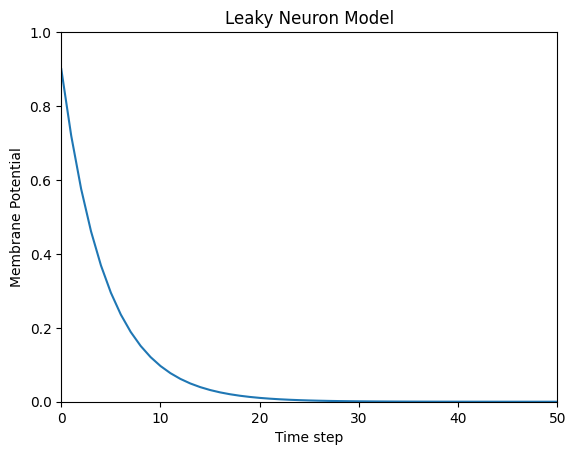

In [5]:
num_steps = 100
U = 0.9
U_trace = []  # keeps a record of U for plotting

for step in range(num_steps):
  U_trace.append(U)
  U = leaky_integrate_neuron(U)  # solve next step of U

plot_mem(U_trace, "Leaky Neuron Model")

这种指数衰减似乎符合我们的预期！

# 3 Lapicque 的 LIF 神经元模型

[Louis Lapicque 在 1907 年](https://core.ac.uk/download/pdf/21172797.pdf) 观察到了神经膜和 RC 电路之间的相似性。 他用短暂的电脉冲刺激青蛙的神经纤维，发现神经元膜可以近似为一个有泄漏的电容器。 我们以他的名字命名 snnTorch 中的基本 LIF 神经元模型，以向他的发现致敬。

Lapicque 模型中的大部分概念都继承到了其他 LIF 神经元模型。 现在是时候使用 snnTorch 模拟这个神经元了。

## 3.1 Lapicque: 观察没有刺激的结果

使用以下代码行实例化 Lapicque 的神经元。 R & C 更改为更简单的值，同时保持之前的时间常数 $\tau=5\times10^{-3}$ s。

In [6]:
time_step = 1e-3
R = 5
C = 1e-3

# leaky integrate and fire neuron, tau=5e-3
lif1 = snn.Lapicque(R=R, C=C, time_step=time_step)

神经元模型现在存储在`lif1`中。 要使用这个神经元：

**输入**
* `spk_in`: $I_{\rm in}$ 的每个元素作为输入顺序传递（目前为 0）
* `mem`：膜电位，以前为 $U[t]$，也作为输入传递。 任意初始化为$U[0] = 0.9~V$。

**输出**
* `spk_out`：在下一个时间步输出尖峰$S_{\rm out}[t+\Delta t]$（如果有尖峰则为“1”；如果没有尖峰则为“0”）
* `mem`: 下一时间步的膜电位 $U_{\rm mem}[t+\Delta t]$

这些都需要是`torch.Tensor`类型。

In [7]:
# 初始化膜、输入和输出
mem = torch.ones(1) * 0.9  # U=0.9 at t=0
cur_in = torch.zeros(num_steps)  # I=0 for all t
spk_out = torch.zeros(1)  # 初始化输出尖峰

这些值仅适用于初始时间步 $t=0$ 。

要分析`mem`随时间的演变，请创建一个列表`mem_rec`来记录每个时间步的这些值。

In [8]:
# A list to store recordings of membrane potential
mem_rec = [mem]

现在是时候运行模拟了！ 在每个时间步，`mem`都会更新并存储在`mem_rec`中：

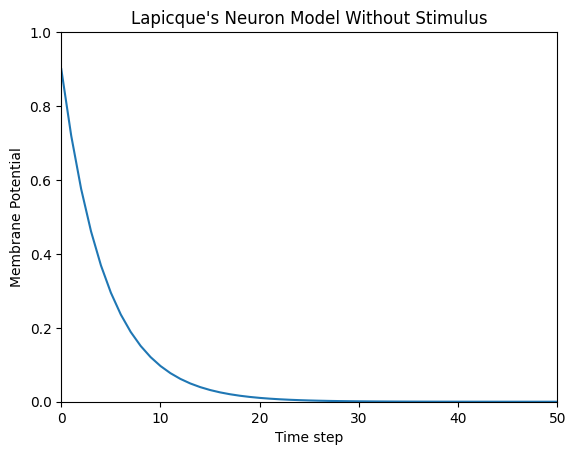

In [9]:
# 在每个时间步传递 mem 和 cur_in [step]=0 的更新值
for step in range(num_steps):
  spk_out, mem = lif1(cur_in[step], mem)

  # 存储膜电位的记录
  mem_rec.append(mem)

# 将张量列表压缩为一个张量
mem_rec = torch.stack(mem_rec)

plot_mem(mem_rec, "Lapicque's Neuron Model Without Stimulus")

在没有任何输入刺激的情况下，膜电位随着时间的推移而衰减。

## 3.2 Lapicque: 步进输入

现在应用在 $t=t_0$ 处开启的阶跃电流 $I_{\rm in}(t)$。 给定线性一阶微分方程：

$$ \tau \frac{dU_{\rm mem}}{dt} = -U_{\rm mem} + RI_{\rm in}(t),$$

一般的解决方案是：

$$U_{\rm mem}=I_{\rm in}(t)R + [U_0 - I_{\rm in}(t)R]e^{-\frac{t}{\tau}}$$

如果膜电位初始化为 $U_{\rm mem}(t=0) = 0 V$，则：

$$U_{\rm mem}(t)=I_{\rm in}(t)R [1 - e^{-\frac{t}{\tau}}]$$

基于这种显式的时间相关形式，我们期望 $U_{\rm mem}$ 以指数方式松弛到 $I_{\rm in}R$。 让我们通过在 $t_0 = 10ms$ 处触发 $I_{in}=100mA$ 的电流脉冲来想象一下这是什么样子。

In [10]:
# 初始化输入电流脉冲
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*0.1), 0)  # 输入电流在 t=10 时开启

# 初始化薄膜、输出和记录
mem = torch.zeros(1)  # t=0 时膜电位为 0
spk_out = torch.zeros(1)  # 神经元需要有地方依次转储其输出峰值
mem_rec = [mem]

这一次，`cur_in` 的新值被传递给神经元：

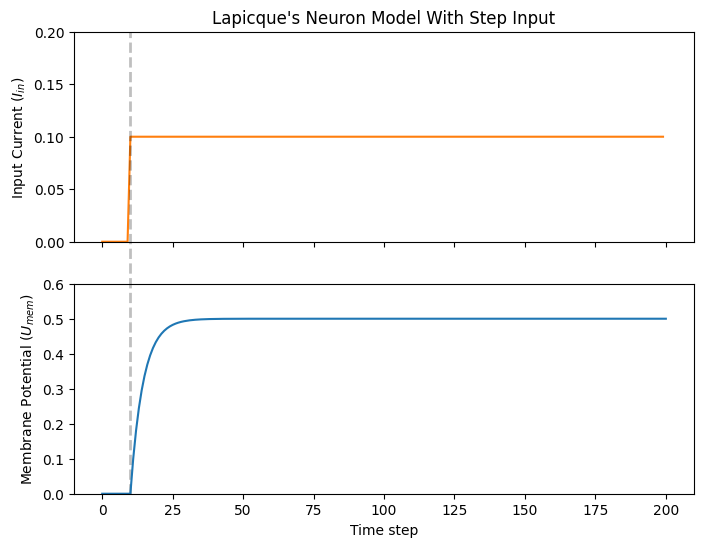

In [11]:
num_steps = 200

# 在每个时间步传递 mem 和 cur_in[step] 的更新值
for step in range(num_steps):
  spk_out, mem = lif1(cur_in[step], mem)
  mem_rec.append(mem)

# 将张量列表压缩成一个张量
mem_rec = torch.stack(mem_rec)

plot_step_current_response(cur_in, mem_rec, 10)

当 $t\rightarrow \infty$ 时，膜电位 $U_{\rm mem}$ 指数松弛到 $I_{\rm in}R$ ：

In [12]:
print(f"The calculated value of input pulse [A] x resistance [Ω] is: {cur_in[11]*lif1.R} V")
print(f"The simulated value of steady-state membrane potential is: {mem_rec[200][0]} V")

The calculated value of input pulse [A] x resistance [Ω] is: 0.5 V
The simulated value of steady-state membrane potential is: 0.4999999403953552 V


已经很接近了！！

## 3.3 Lapicque: 脉冲输入

如果阶跃输入在 $t=30ms$ 时关闭呢？

In [13]:
# 初始化电流脉冲、薄膜和输出端
cur_in1 = torch.cat((torch.zeros(10), torch.ones(20)*(0.1), torch.zeros(170)), 0)  # 输入在 t=10 时打开，在 t=30 时关闭
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec1 = [mem]

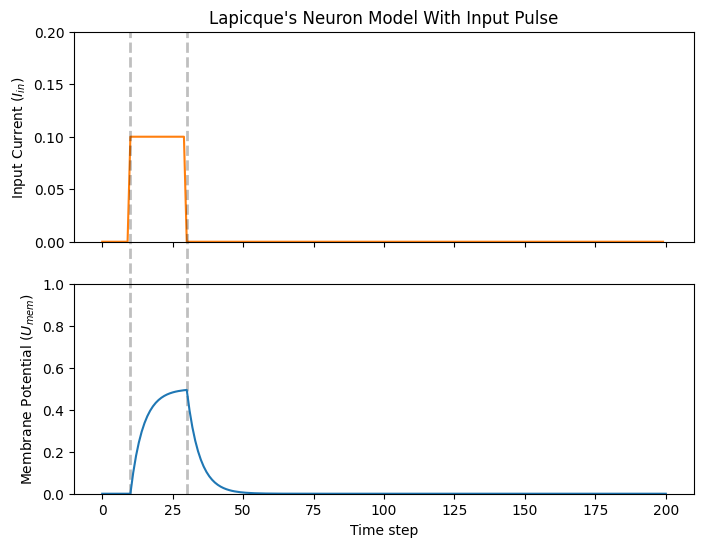

In [14]:
# 神经元仿真
for step in range(num_steps):
  spk_out, mem = lif1(cur_in1[step], mem)
  mem_rec1.append(mem)
mem_rec1 = torch.stack(mem_rec1)

plot_current_pulse_response(cur_in1, mem_rec1, "Lapicque's Neuron Model With Input Pulse",
                            vline1=10, vline2=30)

$U_{\rm mem}$ 和阶跃输入时一样上升，但现在它的衰减时间常数为 $\tau$，就像第一次模拟时一样。

让我们在一半的时间内 向电路提供相同数量的电荷 $Q = I \times t$。这意味着输入电流增加，时间减小。

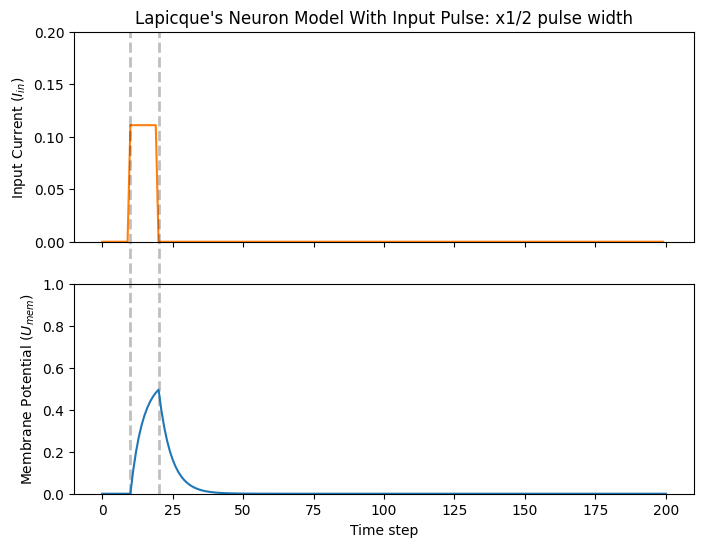

In [15]:
# 增加电流脉冲的振幅；时间减半。
cur_in2 = torch.cat((torch.zeros(10), torch.ones(10)*0.111, torch.zeros(180)), 0)  # input turns on at t=10, off at t=20
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec2 = [mem]

# 神经元仿真
for step in range(num_steps):
  spk_out, mem = lif1(cur_in2[step], mem)
  mem_rec2.append(mem)
mem_rec2 = torch.stack(mem_rec2)

plot_current_pulse_response(cur_in2, mem_rec2, "Lapicque's Neuron Model With Input Pulse: x1/2 pulse width",
                            vline1=10, vline2=20)

让我们再来一次，但输入脉冲的速度要更快，振幅要更大：

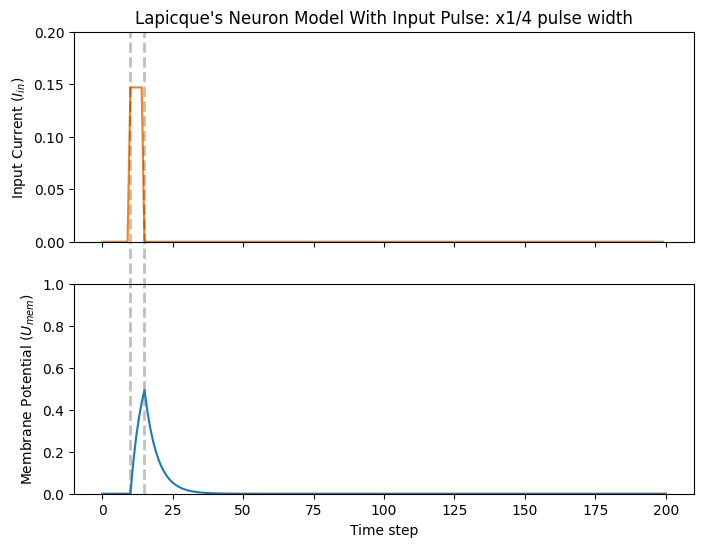

In [16]:
# 增加电流脉冲的振幅；时间缩短四分之一。
cur_in3 = torch.cat((torch.zeros(10), torch.ones(5)*0.147, torch.zeros(185)), 0)  # input turns on at t=10, off at t=15
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec3 = [mem]

# 神经元仿真
for step in range(num_steps):
  spk_out, mem = lif1(cur_in3[step], mem)
  mem_rec3.append(mem)
mem_rec3 = torch.stack(mem_rec3)

plot_current_pulse_response(cur_in3, mem_rec3, "Lapicque's Neuron Model With Input Pulse: x1/4 pulse width",
                            vline1=10, vline2=15)

现在，在同一张图比较三个实验：

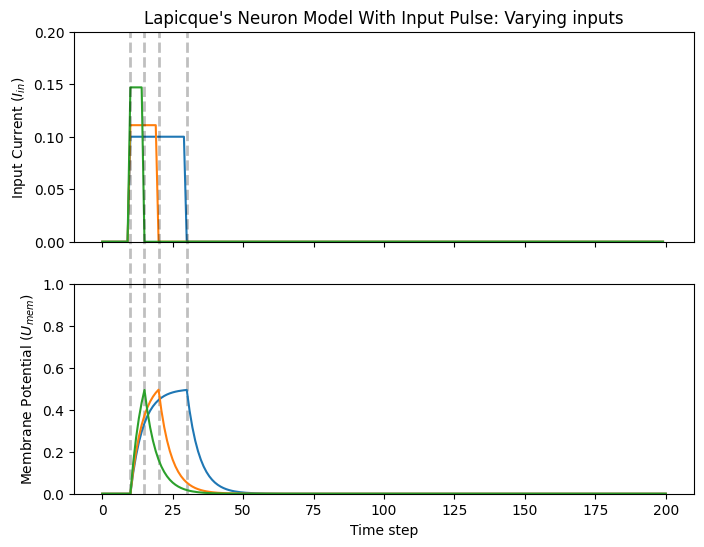

In [17]:
compare_plots(cur_in1, cur_in2, cur_in3, mem_rec1, mem_rec2, mem_rec3, 10, 15,
              20, 30, "Lapicque's Neuron Model With Input Pulse: Varying inputs")

随着输入电流脉冲振幅的增加，膜电位的上升时间也会加快。在输入电流脉冲宽度变得无限小的情况下，即 $T_W \rightarrow 1s$，膜电位将在几乎为零的上升时间内直线上升：

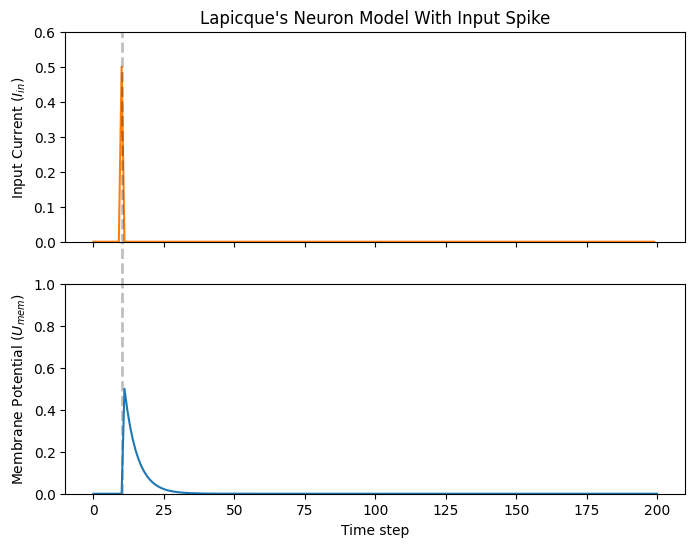

In [18]:
# Current spike input
cur_in4 = torch.cat((torch.zeros(10), torch.ones(1)*0.5, torch.zeros(189)), 0)  # input only on for 1 time step
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec4 = [mem]

# neuron simulation
for step in range(num_steps):
  spk_out, mem = lif1(cur_in4[step], mem)
  mem_rec4.append(mem)
mem_rec4 = torch.stack(mem_rec4)

plot_current_pulse_response(cur_in4, mem_rec4, "Lapicque's Neuron Model With Input Spike",
                            vline1=10, ylim_max1=0.6)

现在的电流脉冲宽度非常短，看起来就像一个尖峰。也就是说，电荷是在无限短的时间内输出的，即 $I_{\rm in}(t) = Q/t_0$，其中 $t_0 \rightarrow 0$。更正式地说

$$I_{\rm in}(t) = Q \delta (t-t_0),$$

其中 $\delta (t-t_0)$ 是狄拉克-德尔塔函数。从物理上讲，不可能 "瞬间 "沉积电荷。但对 $I_{\rm in}$ 进行积分，就能得到一个符合物理原理的结果，因为我们可以得到交付的电荷：

$$1 = \int^{t_0 + a}_{t_0 - a}\delta(t-t_0)dt$$

$$f(t_0) = \int^{t_0 + a}_{t_0 - a}f(t)\delta(t-t_0)dt$$

这里的 $f(t_0) = I_{\rm in}(t_0=10) = 0.5A \implies f(t) = Q = 0.5C$.


希望您能够很好地了解静止时膜电位如何泄漏以及如何积分输入电流。 这涵盖了神经元的 “泄漏 leaky” 和 “整合 integrate” 部分。

那么 “发放 fire” 将如何呢？

注： LIF = 带泄漏整合发放模型（leaky integrate-and-fire model）

## 3.4 Lapicque: Firing (发放)

到目前为止，我们只看到了神经元如何对输入尖峰做出反应。 为了使神经元在输出端生成并发出自己的尖峰，被动膜模型必须与阈值相结合。

如果膜电位超过该阈值，则将在无源膜模型外部产生电压尖峰。

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_4_spiking.png?raw=true' width="450">
</center>


修改之前的 `leaky_integrate_neuron` 函数以添加尖峰响应。

In [19]:
# R=5.1, C=5e-3 for illustrative purposes
def leaky_integrate_and_fire(mem, cur=0, threshold=1, time_step=1e-3, R=5.1, C=5e-3):
  tau_mem = R*C
  spk = (mem > threshold) # if membrane exceeds threshold, spk=1, else, 0
  mem = mem + (time_step/tau_mem)*(-mem + cur*R)
  return mem, spk

设置 `threshold=1`，并应用阶跃电流以使该神经元产生尖峰。

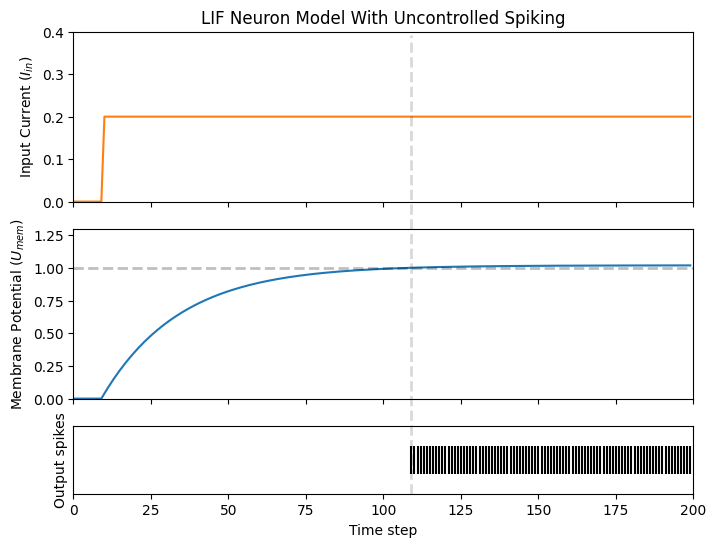

In [20]:
# 小步电流输入
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*0.2), 0)
mem = torch.zeros(1)
mem_rec = []
spk_rec = []

# 神经元仿真
for step in range(num_steps):
  mem, spk = leaky_integrate_and_fire(mem, cur_in[step])
  mem_rec.append(mem)
  spk_rec.append(spk)

# 将列表转换为张量
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, vline=109, ylim_max2=1.3,
                 title="LIF Neuron Model With Uncontrolled Spiking")

糟糕 - 输出尖峰已经失控！这是因为我们忘记添加重置机制。 

事实上，每次神经元放电时，膜电位都会回到静止电位。

在我们的神经元中实现这种重置机制：

In [21]:
# LIF w/Reset mechanism
def leaky_integrate_and_fire(mem, cur=0, threshold=1, time_step=1e-3, R=5.1, C=5e-3):
  tau_mem = R*C
  spk = (mem > threshold)
  mem = mem + (time_step/tau_mem)*(-mem + cur*R) - spk*threshold  # every time spk=1, subtract the threhsold
  return mem, spk

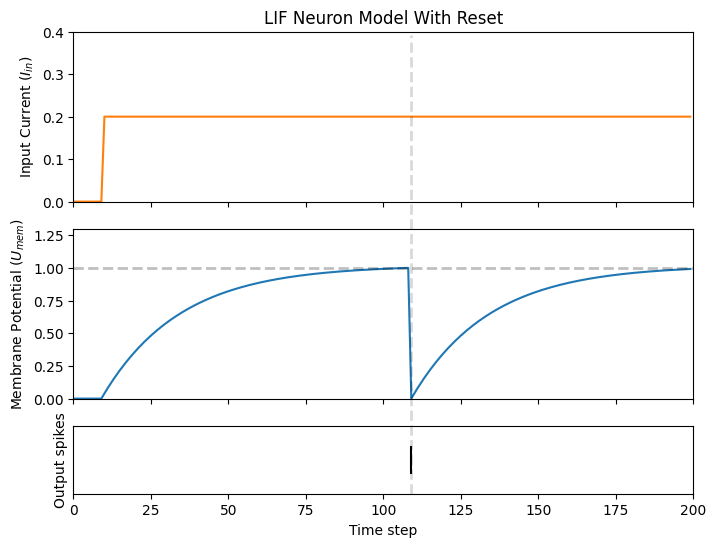

In [22]:
# 小步电流输入
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*0.2), 0)
mem = torch.zeros(1)
mem_rec = []
spk_rec = []

# 神经元仿真
for step in range(num_steps):
  mem, spk = leaky_integrate_and_fire(mem, cur_in[step])
  mem_rec.append(mem)
  spk_rec.append(spk)

# 将列表转换为张量
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, vline=109, ylim_max2=1.3,
                 title="LIF Neuron Model With Reset")

正啦！我们现在有了一个功能性泄漏集成和激发神经元模型！

请注意，如果 $I_{\rm in}=0.2 A$ 且 $R<5 \Omega$，则 $I\times R < 1 V$。  如果 `threshold = 1`，则不会发生尖峰。  请随意返回，更改值并进行测试。

和以前一样，所有代码都是通过从 snnTorch 调用内置 Lapicque 神经元模型来压缩的：

In [23]:
# 使用 snnTorch 创建与之前相同的神经元
lif2 = snn.Lapicque(R=5.1, C=5e-3, time_step=1e-3)

print(f"Membrane potential time constant: {lif2.R * lif2.C:.3f}s")

Membrane potential time constant: 0.025s


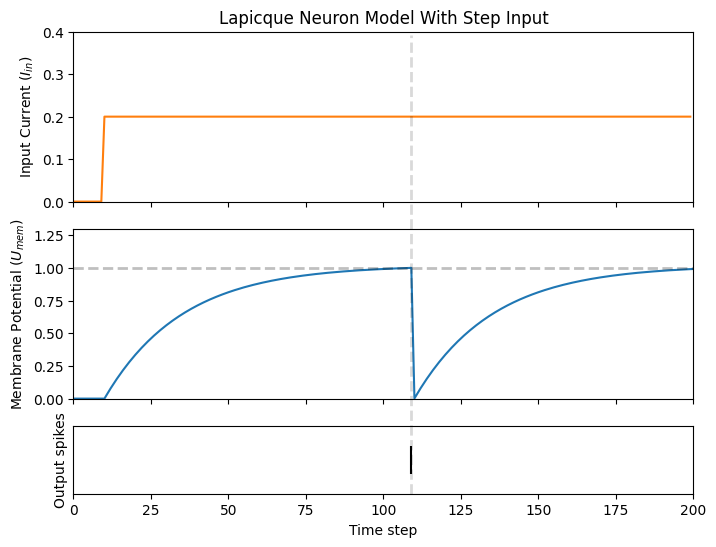

In [24]:
# 初始化输入和输出
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*0.2), 0)
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec = [mem]
spk_rec = [spk_out]

# 模拟运行 100 个时间步长。
for step in range(num_steps):
  spk_out, mem = lif2(cur_in[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk_out)

# 将列表转换为张量
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, vline=109, ylim_max2=1.3,
                 title="Lapicque Neuron Model With Step Input")

膜电位呈指数上升，然后达到阈值，此时它会重置。 我们可以粗略地看到这发生在 $105ms < t_{\rm spk} < 115ms$ 之间。 出于好奇，让我们看看峰值记录实际上包含什么：

In [25]:
print(spk_rec[105:115].view(-1))

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])


没有尖峰的情况用$S_{\rm out}=0$表示，出现尖峰的情况用$S_{\rm out}=1$表示。 此处，峰值出现在 $S_{\rm out}[t=109]=1$ 处。 如果您很想知道为什么每个条目都存储为张量，在未来的教程中我们将模拟大规模神经网络。每个条目将包含许多神经元的尖峰响应，并且张量可以加载到 GPU 内存中以加快训练过程。

如果 $I_{\rm in}$ 增加，则膜电位会更快地接近阈值 $U_{\rm thr}$：

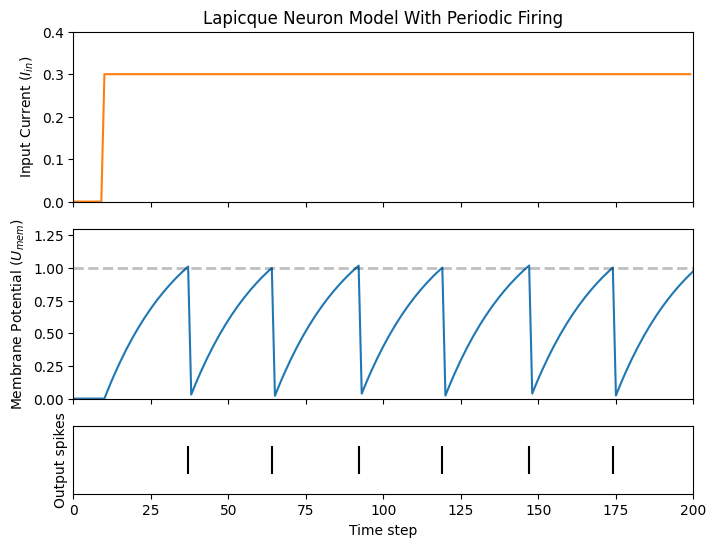

In [26]:
# Initialize inputs and outputs
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*0.3), 0)  # increased current
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec = [mem]
spk_rec = [spk_out]

# neuron simulation
for step in range(num_steps):
  spk_out, mem = lif2(cur_in[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk_out)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)


plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, ylim_max2=1.3,
                 title="Lapicque Neuron Model With Periodic Firing")

通过降低阈值也可以引起发射频率的类似增加。  这需要初始化一个新的神经元模型，但代码块的其余部分与上面完全相同：

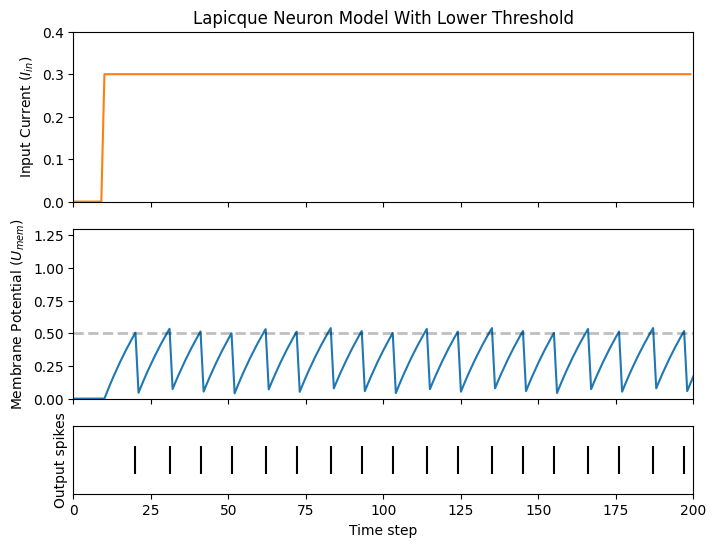

In [27]:
# neuron with halved threshold
lif3 = snn.Lapicque(R=5.1, C=5e-3, time_step=1e-3, threshold=0.5)

# Initialize inputs and outputs
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*0.3), 0)
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec = [mem]
spk_rec = [spk_out]

# Neuron simulation
for step in range(num_steps):
  spk_out, mem = lif3(cur_in[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk_out)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=0.5, ylim_max2=1.3,
                 title="Lapicque Neuron Model With Lower Threshold")

这就是恒流注入时发生的情况。 但在深层神经网络和生物大脑中，大多数神经元都会与其他神经元相连。

## 3.5 Lapicque: 尖峰输入

让我们利用在[教程 2](https://colab.research.google.com/github/jeshraghian/snntorch/blob/tutorials/examples/tutorial_1_spikegen.ipynb) 中学到的一些技能，并使用 `snntorch.spikegen ` 模块创建一些随机生成的输入尖峰。

In [28]:
# 创建一维随机尖峰序列。每个元素都有 40% 的是1。
spk_in = spikegen.rate_conv(torch.ones((num_steps)) * 0.40)

运行以下代码块以查看生成了多少个尖峰。

There are 75 total spikes out of 200 time steps.


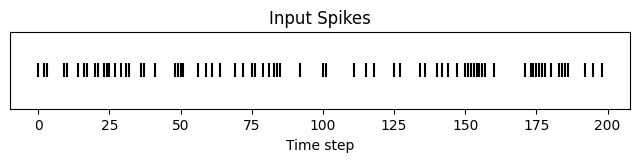

In [29]:
print(f"There are {int(sum(spk_in))} total spikes out of {len(spk_in)} time steps.")

fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

splt.raster(spk_in.reshape(num_steps, -1), ax, s=100, c="black", marker="|")
plt.title("Input Spikes")
plt.xlabel("Time step")
plt.yticks([])
plt.show()

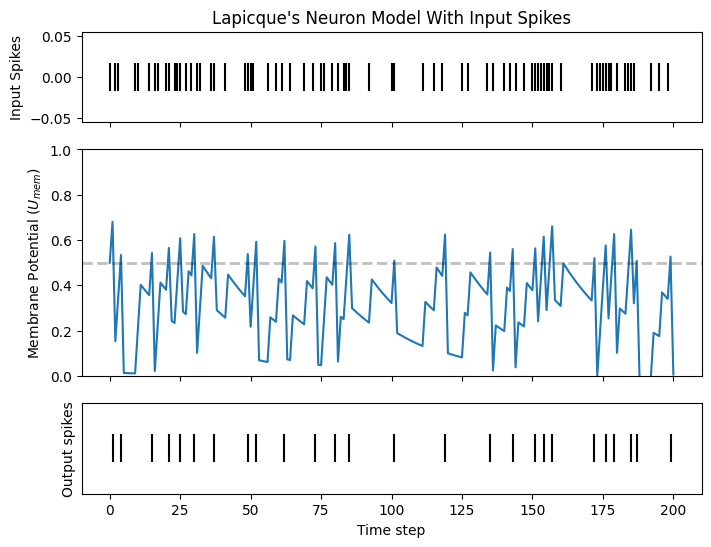

In [30]:
# Initialize inputs and outputs
mem = torch.ones(1)*0.5
spk_out = torch.zeros(1)
mem_rec = [mem]
spk_rec = [spk_out]

# Neuron simulation
for step in range(num_steps):
  spk_out, mem = lif3(spk_in[step], mem)
  spk_rec.append(spk_out)
  mem_rec.append(mem)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_spk_mem_spk(spk_in, mem_rec, spk_out, "Lapicque's Neuron Model With Input Spikes")

## 3.6 Lapicque：重置机制

我们已经从头开始实现了重置机制，但让我们更深入地研究一下。 膜电位的急剧下降促进了尖峰产生的减少，这也是大脑为何如此高效的理论依据之一。 在生物学上，这种膜电位下降被称为 "超极化"。之后，从神经元诱发另一个尖峰瞬间变得更加困难。在这里，我们使用重置机制来模拟超极化。

重置机制有两种实现方式：

1. *通过减法重置*（默认）$-$每次产生尖峰时从膜电位中减去阈值；
2. *重置为零* $-$ 每次产生尖峰时都会强制膜电位为零。
3. *不重置* $-$ 什么也不做，并且让尖峰可能不受控制。

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_5_reset.png?raw=true' width="450">
</center>

实例化另一个神经元模型，演示如何交替使用复位机制。

默认情况下，snnTorch 神经元模型使用 `reset_mechanism = "subtract"`。

可以通过参数 `reset_mechanism = "zero"` 来显式地重载这一机制。

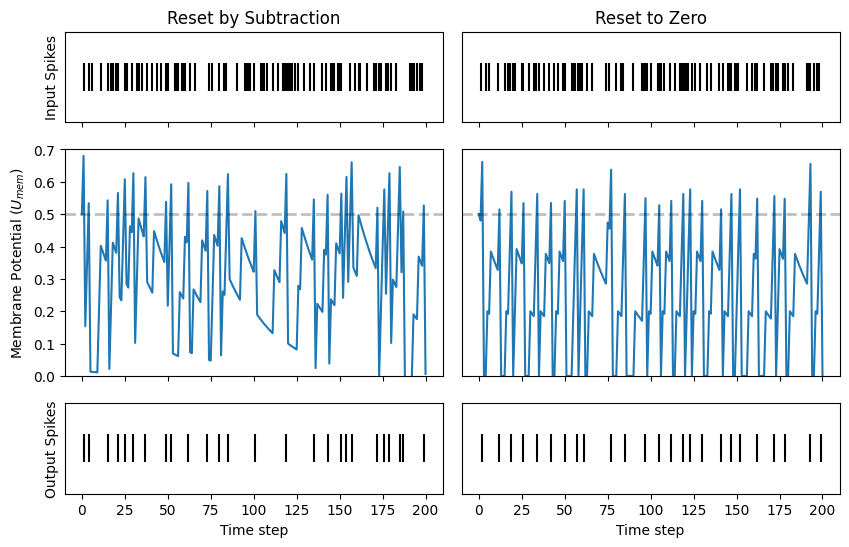

In [31]:
# Neuron with reset_mechanism set to "zero"
lif4 = snn.Lapicque(R=5.1, C=5e-3, time_step=1e-3, threshold=0.5, reset_mechanism="zero")

# Initialize inputs and outputs
spk_in = spikegen.rate_conv(torch.ones((num_steps)) * 0.40)
mem = torch.ones(1)*0.5
spk_out = torch.zeros(1)
mem_rec0 = [mem]
spk_rec0 = [spk_out]

# Neuron simulation
for step in range(num_steps):
  spk_out, mem = lif4(spk_in[step], mem)
  spk_rec0.append(spk_out)
  mem_rec0.append(mem)

# convert lists to tensors
mem_rec0 = torch.stack(mem_rec0)
spk_rec0 = torch.stack(spk_rec0)

plot_reset_comparison(spk_in, mem_rec, spk_rec, mem_rec0, spk_rec0)

密切关注膜电位的变化，尤其是膜电位达到阈值后的瞬间。您可能会注意到，对于 "重置为零"，膜电位在每个尖峰后都会被迫回到零。

那么哪种方法更好呢？应用 "减法"（reset_mechanism 的默认值）损失较少，因为它不会忽略膜电位超出阈值的程度。

另一方面，在专用神经形态硬件上运行时，使用`"零"`进行硬重置可提高稀疏性，并可能降低功耗。这两个选项你都可以尝试。

这就是 LIF 神经元模型的基本原理！

# 总结

实际上，我们可能不会用这种神经元模型来训练神经网络。Lapicque LIF 模型增加了很多需要调整的超参数：$R$、$C$、$\Delta t$、$U_{\rm thr}$，以及重置机制的选择。这一切都有点令人生畏。因此，[下一篇教程](https://snntorch.readthedocs.io/en/latest/tutorials/index.html) 将取消其中大部分超参数，并引入更适合大规模深度学习的神经元模型。

文档[可在此处](https://snntorch.readthedocs.io/en/latest/snntorch.html)查阅，以供参考。

如果你喜欢这个项目，请考虑在 GitHub 上的 repo ⭐ 星级，因为这是最简单、最好的支持方式。

## Further Reading
* [Check out the snnTorch GitHub project here.](https://github.com/jeshraghian/snntorch)
* [snnTorch documentation](https://snntorch.readthedocs.io/en/latest/snntorch.html) of the Lapicque, Leaky, Synaptic, and Alpha models
* [*Neuronal Dynamics:
From single neurons to networks and models of cognition*](https://neuronaldynamics.epfl.ch/index.html) by
Wulfram Gerstner, Werner M. Kistler, Richard Naud and Liam Paninski.
* [Theoretical Neuroscience: Computational and Mathematical Modeling of Neural Systems](https://mitpress.mit.edu/books/theoretical-neuroscience) by Laurence F. Abbott and Peter Dayan